# Model Prototype

Training an LSTM model to predict future bitcoin prices given the return values and trend values

In [1]:
from pandas import read_csv, DataFrame, concat

#import dask.dataframe as dd
#from dask_ml.preprocessing import StandardScaler 

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import Model
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

Using TensorFlow backend.


### Load and reshape data

In [2]:
# load dataset as Dask DataFrame and separate dates 
btc_df = read_csv('../data/processed/price_trend_data.csv')
dates = btc_df.date
dataset = btc_df.drop('date', axis=1)

scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

split = int(0.7 * len(dataset))
train = dataset[:split]
test = dataset[split:]

### LSTM Model

Here we implement a similar Keras model with the TimeseriesGenerator. This Data Generator structure from Keras makes it possible to train data in batches which would be required if the data being used was larger than the available RAM. Another option considered for scaling the model was to use Dask DataFrames instead of those from Pandas. Dask DataFrames allow for certain computations to be computed in parallel over available cores, but Dask DataFrames do not support the .iloc method that normal DataFrames do which makes working with Keras and time-series data more difficult. 

In [3]:
dropout = 0.5
nodes = 64
epochs = 20
look_back = 10

train_gen = TimeseriesGenerator(train, train[:, 1], length=look_back, batch_size=50)
test_gen = TimeseriesGenerator(test, test[:, 1], length=look_back, batch_size=50)

model = Sequential()
model.add(LSTM(nodes, return_sequences=True, input_shape=(look_back, 2)))
model.add(Dropout(dropout))
model.add(LSTM(nodes))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_gen, epochs=epochs, validation_data=test_gen).history
model.evaluate_generator(test_gen)
train_predict = model.predict_generator(train_gen)
test_predict = model.predict_generator(test_gen)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





30/30 [==============================] - 4s 141ms/step - loss: 1.0203 - val_loss: 0.9841
Epoch 2/20
30/30 [==============================] - 1s 42ms/step - loss: 1.0164 - val_loss: 0.9857
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 1.0100 - val_loss: 0.9896
Epoch 4/20
30/30 [==============================] - 1s 44ms/step - loss: 1.0090 - val_loss: 0.9924
Epoch 5/20
30/30 [==============================] - 2s 58ms/step - loss: 1.0103 - val_loss: 0.9979
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 1.0076 - val_loss: 0.9879
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - loss: 1.0028 - val_loss: 1.0054
Epoch 8/20
30/30 [==============================] - 2s 68ms/step - loss: 1.0030 - va

In [4]:
# serialize model to JSON
model_json = model.to_json()
with open("model_scaled.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model_scaled.h5")
print("Saved model to disk")

Saved model to disk


### Diagnostics

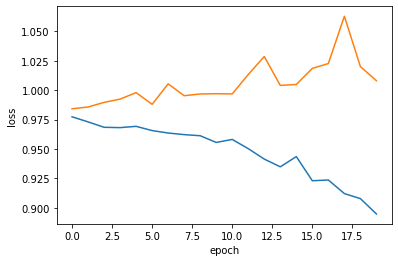

In [5]:
# It is unclear how I can compute validation loss while using the generator functions
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [6]:
# calculate mean squared error
train_score = mean_squared_error(DataFrame(train[10:, 1]), train_predict)
print('Train Score: %.4f MSE' % (train_score))
test_score = mean_squared_error(DataFrame(test[10:, 1]), test_predict)
print('Test Score: %.4f MSE' % (test_score))

Train Score: 0.8755 MSE
Test Score: 1.0080 MSE


When trained on batches the model doesn't seem to perform well on testing data and requires further tuning, but as the purpose of this notebook is to explore a scaling method and is not necessary for our data we can look to improve this in the future. I would like to understand better the effects of batching and using the generators compared to feeding the data directly to the model.

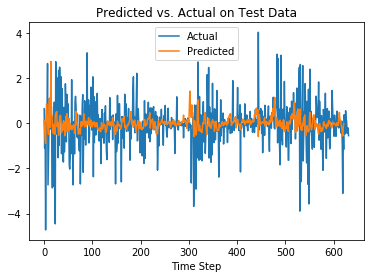

In [21]:
# compare predicitons on test data
plt.plot(test[:, 1])
plt.plot(test_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Test Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

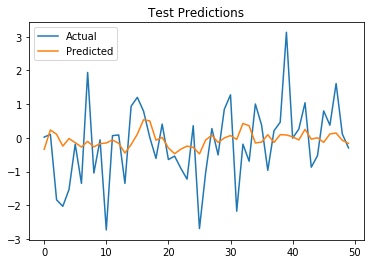

In [18]:
# closer look
plt.plot(test[50:100, 1])
plt.plot(test_predict[50:100])
plt.title('Test Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()

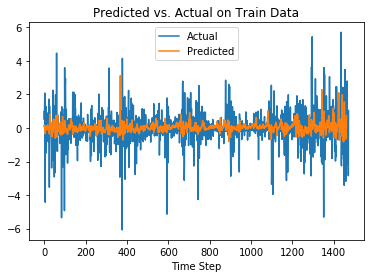

In [19]:
# compare predictions on train data
plt.plot(train[:, 1])
plt.plot(train_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Train Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

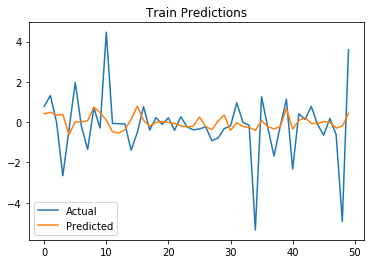

In [20]:
plt.plot(train[50:100, 1])
plt.plot(train_predict[50:100])
plt.title('Train Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()